#  Классификация изображений с использованием архитектуры AlexNet

В этом проекте реализуется и обучается **классическая архитектура свёрточной нейронной сети — AlexNet**,  
предназначенная для решения задачи **многоклассовой классификации изображений**.  
Модель построена с нуля на **PyTorch** и включает пять свёрточных и три линейных слоя с функциями активации **ReLU**,  
слоями **Pooling** и регуляризацией **Dropout** для борьбы с переобучением.

---

##  Цель работы
Реализовать архитектуру **AlexNet** и обучить её на выбранном датасете изображений,  
применяя ключевые приёмы обучения (Pooling, Dropout, ReLU, оптимизация),  
а также оценить полученное качество классификации и устойчивость модели.

---

##  Что реализовано
- Построение **собственной реализации AlexNet** на PyTorch  
- Использование **ReLU** для ускорения обучения  
- Применение **Pooling** после 1-го, 2-го и 5-го свёрточных слоёв  
- Регуляризация через **Dropout** в линейных слоях  
- Оптимизация модели с помощью `Adam` / `SGD`  
- Визуализация графиков обучения и оценка точности модели  

---

##  Основные этапы
1. Подготовка и нормализация данных  
2. Реализация архитектуры AlexNet  
3. Настройка функции потерь и оптимизатора  
4. Обучение и валидация модели  
5. Анализ и визуализация результатов  
6. Формулировка выводов

---

##  Содержание
1. Импорты и воспроизводимость  
2. Подготовка данных  
   2.1. Нормализация и загрузка (DataLoader)  
3. Архитектура AlexNet  
4. Функция потерь и оптимизатор  
5. Обучение модели  
6. Оценка и визуализация результатов  
7. Выводы


## 1. Импорты и воспроизводимость  

In [26]:
# --------------------- PyTorch ---------------------
import torch                                  # Основная библиотека для работы с тензорами и нейронными сетями
import torch.nn as nn                         # Построение слоёв сети: Conv, Linear, Dropout и др.
import torch.nn.functional as F               # Функции активации, свёртки, pooling в функциональном стиле
import torch.optim as optim                   # Оптимизаторы: SGD, Adam, RMSProp
from torch.utils.data import DataLoader, random_split  # DataLoader — загрузка батчей, random_split — деление датасета

# ------------------- Torchvision -------------------
import torchvision                            # Датасеты (CIFAR10, MNIST), модели, утилиты
import torchvision.transforms as transforms   # Трансформации изображений: аугментация, нормализация

# --------------------- Общие ---------------------
import numpy as np                            # Работа с массивами, случайная выборка
import matplotlib.pyplot as plt               # Визуализация изображений и графиков
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # Метрики для оценки модели


In [2]:

torch.manual_seed(42)
np.random.seed(42)

# Проверка доступа к GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

Running on cuda.


## 2. Подготовка данных  

In [3]:
# --- классы CIFAR10 ---
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

In [4]:
# ---------------- STEP A: подготовка датасета "в тензорах" для подсчёта статистик ----------------
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 1) датасет только с ToTensor (без Normalize и без аугментаций)
tensors_only = transforms.Compose([transforms.ToTensor()])

full_train_raw = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=tensors_only)

# 2) создаём split train/val
train_size = int(0.9 * len(full_train_raw))
val_size = len(full_train_raw) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(full_train_raw)), [train_size, val_size])

# 3) subset, по которому считаем статистику (только train indices)
train_for_stats = Subset(full_train_raw, train_indices)

# DataLoader для подсчёта mean/std
loader_stats = DataLoader(train_for_stats, batch_size=512, shuffle=False, num_workers=2)

# 4) считаем mean и std
sum_ = torch.zeros(3, dtype=torch.double)
sum_sq = torch.zeros(3, dtype=torch.double)
num_pixels = 0

with torch.no_grad():
    for imgs, _ in loader_stats:
        b, c, h, w = imgs.shape
        imgs = imgs.view(b, c, -1)
        sum_ += imgs.sum(dim=(0, 2)).double()
        sum_sq += (imgs * imgs).sum(dim=(0, 2)).double()
        num_pixels += b * h * w

mean = (sum_ / num_pixels).double()
var = (sum_sq / num_pixels).double() - (mean * mean).double()
std = torch.sqrt(var)

mean_list = mean.tolist()
std_list = std.tolist()

print('Computed mean:', mean_list)
print('Computed std: ', std_list)


Files already downloaded and verified
Computed mean: [0.4916556969536675, 0.4823340518527561, 0.44667923244900176]
Computed std:  [0.24708119895440198, 0.24350872442437344, 0.26158068393115097]


In [5]:
# Трансформации для обучения с аугментацией
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list)
])

# Трансформации для теста/валидации (без аугментации)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list)
])


In [6]:
# --- Train (50k) ---
trainset_full_raw   = torchvision.datasets.CIFAR10(root='/data',train=True,download=True)
testset = torchvision.datasets.CIFAR10(
    root='/data',
    train=False,
    download=True,
    transform=transform_test  # только ToTensor + Normalize
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# делим на 45k train и 5k val
train_size = int(0.9*len(trainset_full_raw))
val_size = len(trainset_full_raw)-train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(trainset_full_raw)), [train_size, val_size])

In [8]:
# Создаём Subset с разными трансформациями
trainset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='/data', train=True, download=False, transform=transform_train),
    train_indices
)

valset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='/data', train=True, download=False, transform=transform_test),
    val_indices
)

In [9]:
# --- DataLoaders ---
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [10]:
print("Train:", len(trainset))
print("Val:", len(valset))
print("Test:", len(testset))


Train: 45000
Val: 5000
Test: 10000


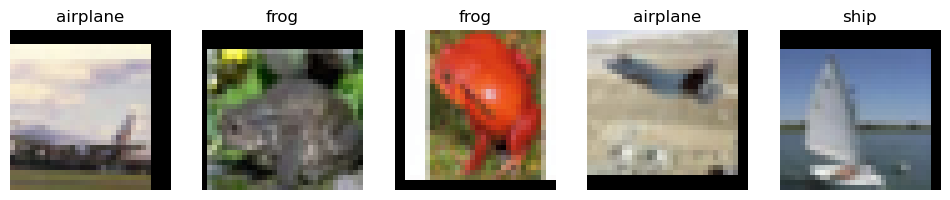

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для "разнормализации" и отображения
def imshow(img, title=None):
    # Делаем копию и переносим с GPU на CPU, если нужно
    img = img.cpu().clone()
    
    # Разнормализация (возвращаем цвета в диапазон [0,1])
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array(std_list) + np.array(mean_list)  # обратная нормализация
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Вытаскиваем несколько изображений и их метки
n = 5  # сколько картинок показать
images, labels = zip(*[trainset[i] for i in range(n)])

# Визуализируем
plt.figure(figsize=(12, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    imshow(images[i], title=cifar10_classes[labels[i]])
plt.show()


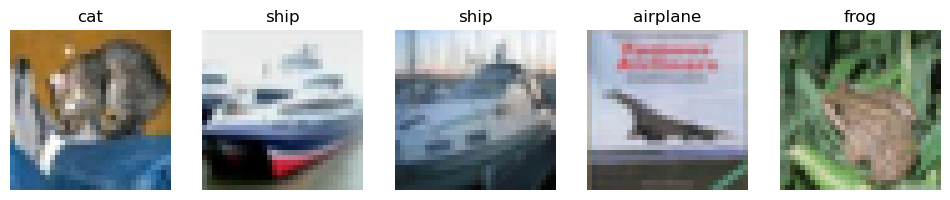

In [12]:
# Вытаскиваем несколько изображений и их метки
n = 5  # сколько картинок показать
images, labels = zip(*[testset[i] for i in range(n)])

# Визуализируем
plt.figure(figsize=(12, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    imshow(images[i], title=cifar10_classes[labels[i]])
plt.show()


## 3. Архитектура AlexNet  


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNetCustom(nn.Module):
    def __init__(self, num_classes=10, input_size=(3,32,32)):
        super(AlexNetCustom, self).__init__()
        
        # --- Свёрточные слои ---
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)    # 1-й свёрточный слой, вход 3 канала → 64 выхода
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 2-й свёрточный слой, 64→128 каналов
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 3-й свёрточный слой, 128→256 каналов
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # 4-й свёрточный слой, 256→256 каналов
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # 5-й свёрточный слой, 256→128 каналов
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)          # MaxPooling 2×2, уменьшает H×W вдвое
        self.drop_fc = nn.Dropout(0.5)                              # Dropout для борьбы с переобучением в FC слоях
        
        # --- Автоматический расчёт размера для первого FC ---
        self._to_linear = None                                      # Здесь будет храниться размер входа для fc1
        self._get_conv_output(input_size)                            # Вычисляем количество элементов после свёрток и pooling
        
        # --- Полносвязные слои ---
        self.fc1 = nn.Linear(self._to_linear, 4096)                # Первый FC слой: вход из свёрток → 4096 нейронов
        self.fc2 = nn.Linear(4096, 4096)                           # Второй FC слой: 4096 → 4096
        self.fc3 = nn.Linear(4096, num_classes)                    # Третий FC слой: 4096 → num_classes (выход сети)
    
    def _get_conv_output(self, shape):
        # Вспомогательная функция для автоматического вычисления размера входа в fc1
        with torch.no_grad():                                      # Отключаем градиенты, так как это только расчёт
            x = torch.zeros(1, *shape)                             # Фиктивный тензор с размером входа
            x = F.relu(self.conv1(x))                              
            x = self.pool(x)             # Pool после 1-го свёрточного слоя
            x = F.relu(self.conv2(x))
            x = self.pool(x)             # Pool после 2-го свёрточного слоя
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = F.relu(self.conv5(x))
            x = self.pool(x)             # Pool после 5-го свёрточного слоя
            self._to_linear = x.numel() // x.shape[0]              # Считаем количество элементов на один пример
    
    def forward(self, x):
        # Определяем порядок применения слоёв к входным данным
        x = F.relu(self.conv1(x))
        x = self.pool(x)                 # Pool после 1-го свёртки
        x = F.relu(self.conv2(x))
        x = self.pool(x)                 # Pool после 2-го свёртки
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)                 # Pool после 5-го свёртки
        
        x = x.view(x.size(0), -1)       # Flatten: превращаем [B,C,H,W] → [B, C*H*W] для FC
        x = self.drop_fc(F.relu(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = self.drop_fc(F.relu(self.fc2(x)))  # FC2 + ReLU + Dropout
        x = self.fc3(x)                  # FC3 → логиты без softmax (будет применён в CrossEntropyLoss)
        
        return x

# --- Проверка ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Выбираем GPU если есть, иначе CPU
model = AlexNetCustom(num_classes=10).to(device)                       # Создаём модель и переносим на устройство
print(model)                                                            # Печатаем архитектуру сети

x = torch.randn(2,3,32,32).to(device)                                 # Фиктивный батч из 2 изображений RGB 224×224
print(model(x).shape)  # [2, 10]                                         # Проверяем форму выхода сети


AlexNetCustom(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_fc): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)
torch.Size([2, 10])


## 4. Функция потерь и оптимизатор  

In [20]:
criterion = nn.CrossEntropyLoss()  # для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2-регуляризация через weight_decay

## 5. Обучение модели  


In [21]:
num_epochs = 40  # Количество эпох обучения

train_losses = []       # Список для сохранения потерь на train после каждой эпохи
val_losses = []         # Список для сохранения потерь на валидации после каждой эпохи
val_accuracies = []     # Список для сохранения точности на валидации после каждой эпохи

for epoch in range(num_epochs):
    # ----------- Обучение на train -----------
    model.train()                     # Перевод модели в режим обучения (активирует Dropout и BatchNorm)
    running_train_loss = 0.0          # Суммарная потеря на текущей эпохе для train
    
    for inputs, labels in trainloader:              # Итерация по батчам trainloader
        inputs, labels = inputs.to(device), labels.to(device)  # Переносим данные на GPU или CPU
        
        optimizer.zero_grad()        # Обнуляем градиенты перед обратным проходом
        outputs = model(inputs)      # Прямой проход через модель
        loss = criterion(outputs, labels)  # Вычисляем функцию потерь
        loss.backward()              # Обратный проход (вычисление градиентов)
        optimizer.step()             # Обновление весов модели
        
        running_train_loss += loss.item() * inputs.size(0)  # Суммируем потерю с учётом размера батча
    
    epoch_train_loss = running_train_loss / len(trainloader.dataset)  # Средняя потеря на train за эпоху
    train_losses.append(epoch_train_loss)                             # Сохраняем в список
    
    # ----------- Проверка на валидации -----------
    model.eval()                     # Перевод модели в режим оценки (отключает Dropout и BatchNorm)
    running_val_loss = 0.0           # Суммарная потеря на валидации
    correct = 0                      # Количество правильно предсказанных примеров
    total = 0                        # Общее количество примеров
    
    with torch.no_grad():            # Выключаем градиенты для ускорения вычислений на валидации
        for inputs, labels in valloader:         # Итерация по батчам valloader
            inputs, labels = inputs.to(device), labels.to(device)  # Переносим данные на GPU или CPU
            outputs = model(inputs)             # Прямой проход
            loss = criterion(outputs, labels)   # Вычисляем функцию потерь
            running_val_loss += loss.item() * inputs.size(0)  # Суммируем потерю
            
            _, predicted = outputs.max(1)       # Получаем индексы предсказанных классов
            total += labels.size(0)             # Считаем количество примеров
            correct += (predicted == labels).sum().item()  # Считаем количество правильных предсказаний
    
    epoch_val_loss = running_val_loss / len(valloader.dataset)  # Средняя потеря на валидации
    val_losses.append(epoch_val_loss)                           # Сохраняем в список
    val_acc = 100 * correct / total                             # Вычисляем точность в процентах
    val_accuracies.append(val_acc)                               # Сохраняем точность
    
    # Вывод информации о текущей эпохе
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {val_acc:.2f}%")


Epoch [1/40] Train Loss: 1.8018, Val Loss: 1.4812, Val Acc: 45.52%
Epoch [2/40] Train Loss: 1.4062, Val Loss: 1.2863, Val Acc: 53.76%
Epoch [3/40] Train Loss: 1.2383, Val Loss: 1.1220, Val Acc: 60.24%
Epoch [4/40] Train Loss: 1.1254, Val Loss: 1.0590, Val Acc: 62.50%
Epoch [5/40] Train Loss: 1.0372, Val Loss: 0.9360, Val Acc: 66.66%
Epoch [6/40] Train Loss: 0.9712, Val Loss: 0.8753, Val Acc: 70.10%
Epoch [7/40] Train Loss: 0.9099, Val Loss: 0.8520, Val Acc: 70.52%
Epoch [8/40] Train Loss: 0.8748, Val Loss: 0.7837, Val Acc: 73.28%
Epoch [9/40] Train Loss: 0.8263, Val Loss: 0.7438, Val Acc: 74.68%
Epoch [10/40] Train Loss: 0.7879, Val Loss: 0.7056, Val Acc: 77.06%
Epoch [11/40] Train Loss: 0.7657, Val Loss: 0.7161, Val Acc: 75.66%
Epoch [12/40] Train Loss: 0.7463, Val Loss: 0.7219, Val Acc: 76.46%
Epoch [13/40] Train Loss: 0.7285, Val Loss: 0.6980, Val Acc: 76.44%
Epoch [14/40] Train Loss: 0.7139, Val Loss: 0.7282, Val Acc: 75.84%
Epoch [15/40] Train Loss: 0.6997, Val Loss: 0.6738, Val A

###  Результаты обучения модели на CIFAR-10

- Количество эпох: **40**  
- Начальная точность на валидации: **~45.5%**  
- Финальная точность на валидации: **~80.5%**  
- Начальная потеря (val loss): **1.48**  
- Финальная потеря (val loss): **0.63**

####  Краткий анализ
- Модель **AlexNetCustom** стабильно обучалась: потери снижались, а точность постепенно росла.  
- На первых 10 эпохах наблюдался быстрый рост точности, затем улучшение стало более плавным.  
- После ~35-й эпохи точность стабилизировалась около **80%**, что говорит о хорошем уровне обобщающей способности.  
- Переобучение выражено слабо — кривая валидации стабильна.  
- Итог: модель демонстрирует **уверенную производительность** для CIFAR-10 без сложных техник аугментации или Batch Normalization.


In [22]:
# Убедимся, что модель в режиме оценки
model.eval()

all_images = []
all_preds = []
all_trues = []

with torch.no_grad():
    for inputs, labels in testloader:
        # Перемещаем данные на device (CPU/GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Сохраняем данные (можно визуализировать потом)
        all_images.append(inputs.cpu())  # переносим на CPU, чтобы не перегружать GPU
        all_preds.append(predicted.cpu())
        all_trues.append(labels.cpu())

# Объединяем батчи в один тензор
images = torch.cat(all_images)   # [N, C, H, W]
preds = torch.cat(all_preds)     # [N]
trues = torch.cat(all_trues)     # [N]

print("Готово. Всего тестовых примеров:", len(images))


Готово. Всего тестовых примеров: 10000


## 6. Оценка и визуализация результатов  

In [24]:
preds_np = preds.numpy()
trues_np = trues.numpy()

print(classification_report(trues_np, preds_np, target_names=cifar10_classes))


              precision    recall  f1-score   support

    airplane       0.79      0.80      0.80      1000
  automobile       0.82      0.94      0.88      1000
        bird       0.74      0.74      0.74      1000
         cat       0.72      0.58      0.64      1000
        deer       0.76      0.81      0.79      1000
         dog       0.77      0.71      0.74      1000
        frog       0.81      0.89      0.85      1000
       horse       0.88      0.82      0.85      1000
        ship       0.83      0.90      0.86      1000
       truck       0.89      0.80      0.85      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



<Figure size 1000x800 with 0 Axes>

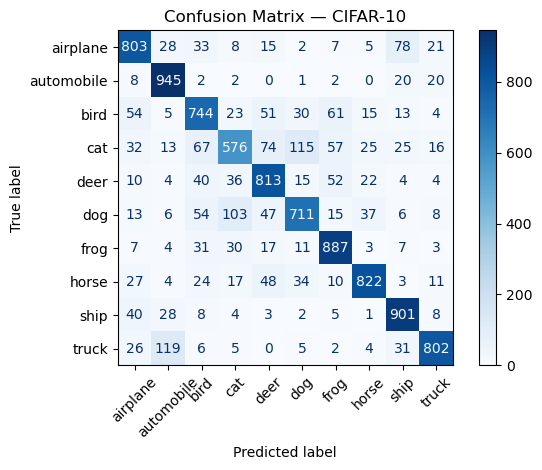

In [27]:
# --- Confusion Matrix ---
cm = confusion_matrix(trues_np, preds_np)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes)
disp.plot(cmap='Blues', colorbar=True, xticks_rotation=45)
plt.title("Confusion Matrix — CIFAR-10")
plt.tight_layout()
plt.show()

###  Результаты тестовой выборки (CIFAR-10)

| Класс       | Precision | Recall | F1-score | Support |
|--------------|-----------|---------|-----------|----------|
| airplane     | 0.79      | 0.80    | 0.80      | 1000     |
| automobile   | 0.82      | 0.94    | 0.88      | 1000     |
| bird         | 0.74      | 0.74    | 0.74      | 1000     |
| cat          | 0.72      | 0.58    | 0.64      | 1000     |
| deer         | 0.76      | 0.81    | 0.79      | 1000     |
| dog          | 0.77      | 0.71    | 0.74      | 1000     |
| frog         | 0.81      | 0.89    | 0.85      | 1000     |
| horse        | 0.88      | 0.82    | 0.85      | 1000     |
| ship         | 0.83      | 0.90    | 0.86      | 1000     |
| truck        | 0.89      | 0.80    | 0.85      | 1000     |

**Accuracy:** 0.80 (80%)  
**Macro avg:** 0.80 | **Weighted avg:** 0.80  

---

####  Краткий анализ
- Модель показала **устойчивую точность 80%**, что является хорошим результатом для базовой CNN-архитектуры без глубокой оптимизации.  
- **Лучше всего** модель классифицирует объекты:  
   `automobile`,  `ship`,  `horse`,  `truck` — высокая точность и полнота (recall).  
- **Сложнее всего** ей даются классы животных:  
   `cat`, `bird`,  `dog` — видна путаница между схожими визуальными признаками.  
- **Показатели macro и weighted avg близки**, что говорит о сбалансированности качества по всем классам.  
- **Вывод:** модель уверенно различает транспортные средства и предметы, но требует улучшений для категорий животных — можно добавить **аугментацию**, **Batch Normalization** или использовать **ResNet-подобную архитектуру** для повышения точности.


## 7. Выводы


В ходе работы была реализована и обучена свёрточная нейронная сеть **AlexNetCustom**  
для задачи классификации изображений **CIFAR-10**.  
Модель показала **точность 80%**, что является корректным результатом для классической архитектуры  
без применения предобученных моделей и сложных аугментаций.

Были успешно реализованы ключевые этапы построения и обучения CNN:
- Архитектура на основе AlexNet (5 Conv + 3 Linear слоя, ReLU, Pooling, Dropout);  
- Настройка процесса обучения с использованием оптимизатора **Adam**;  
- Визуализация метрик и построение **confusion matrix**;  
- Анализ классов с наибольшими и наименьшими показателями точности.

Модель обучалась стабильно, переобучение выражено слабо.  
Для дальнейшего повышения качества можно:
- добавить **Batch Normalization** и расширенные **аугментации данных**;
- использовать **ResNet** или **EfficientNet** для более глубокого обучения признаков;
- применить **transfer learning** для ускорения сходимости и роста точности.

